In [2]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Movie_Capstone').getOrCreate()
from pyspark.sql.functions import col, avg, max, count
import matplotlib.pyplot as plt

In [4]:

users_data = [
(1, "Rahul", 25, "Bangalore"),
(2, "Priya", 30, "Delhi"),
(3, "Aman", 22, "Hyderabad"),
(4, "Sneha", 28, "Chennai"),
(5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

movies_data = [
(101, "Inception", "Sci-Fi", 2010),
(102, "Avengers", "Action", 2012),
(103, "3 Idiots", "Comedy", 2009),
(104, "Dangal", "Drama", 2016),
(105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

ratings_data = [
(1, 101, 5),
(2, 101, 4),
(1, 102, 3),
(3, 103, 4),
(4, 104, 5),
(2, 103, 5),
(5, 105, 4),
(6, 101, 5)  # Rating from non-existent user
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)

In [6]:
users_df.filter(col("age") > 28).show()

+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+



In [8]:
movies_df.select("genre").distinct().show()

+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+



In [10]:
movies_df.filter(col("year")> 2010).show()

+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



In [13]:
users_df.groupBy("city").agg(avg("age").alias("avg_age")).show()

+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   25.0|
|    Delhi|   30.0|
|  Chennai|   28.0|
|   Mumbai|   35.0|
|Hyderabad|   22.0|
+---------+-------+



In [16]:
ratings_df.groupBy("movie_id").agg(avg("rating").alias("avg_rating")).show()

+--------+-----------------+
|movie_id|       avg_rating|
+--------+-----------------+
|     103|              4.5|
|     101|4.666666666666667|
|     102|              3.0|
|     104|              5.0|
|     105|              4.0|
+--------+-----------------+



In [18]:
movies_ratings = ratings_df.join(movies_df, "movie_id")
movies_ratings.groupBy("genre").agg(max("rating").alias("max_rating")).show()

+------+----------+
| genre|max_rating|
+------+----------+
| Drama|         5|
|Comedy|         5|
|Action|         3|
|Sci-Fi|         5|
+------+----------+



In [20]:
rating_users = ratings_df.join(users_df, "user_id", "inner")
rating_users.show()

+-------+--------+------+-----+---+---------+
|user_id|movie_id|rating| name|age|     city|
+-------+--------+------+-----+---+---------+
|      1|     101|     5|Rahul| 25|Bangalore|
|      1|     102|     3|Rahul| 25|Bangalore|
|      2|     101|     4|Priya| 30|    Delhi|
|      2|     103|     5|Priya| 30|    Delhi|
|      3|     103|     4| Aman| 22|Hyderabad|
|      4|     104|     5|Sneha| 28|  Chennai|
|      5|     105|     4|Arjun| 35|   Mumbai|
+-------+--------+------+-----+---+---------+



In [22]:
rating_movies = ratings_df.join(movies_df, "movie_id", "inner")
rating_movies.show()

+--------+-------+------+------------+------+----+
|movie_id|user_id|rating|       title| genre|year|
+--------+-------+------+------------+------+----+
|     101|      1|     5|   Inception|Sci-Fi|2010|
|     101|      2|     4|   Inception|Sci-Fi|2010|
|     101|      6|     5|   Inception|Sci-Fi|2010|
|     102|      1|     3|    Avengers|Action|2012|
|     103|      3|     4|    3 Idiots|Comedy|2009|
|     103|      2|     5|    3 Idiots|Comedy|2009|
|     104|      4|     5|      Dangal| Drama|2016|
|     105|      5|     4|Interstellar|Sci-Fi|2014|
+--------+-------+------+------------+------+----+



In [24]:
users_df.join(ratings_df, "user_id", "left_anti").show()

+-------+----+---+----+
|user_id|name|age|city|
+-------+----+---+----+
+-------+----+---+----+



In [28]:
movies_df.join(ratings_df, "movie_id", "left_anti").show()

+--------+-----+-----+----+
|movie_id|title|genre|year|
+--------+-----+-----+----+
+--------+-----+-----+----+



In [30]:
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")

In [37]:
spark.sql("""
  SELECT u.city, COUNT(r.rating) AS total_ratings
  FROM users u JOIN ratings r ON u.user_id = r.user_id
  GROUP BY u.city
  ORDER BY total_ratings DESC LIMIT 2
  """).show()

+---------+-------------+
|     city|total_ratings|
+---------+-------------+
|Bangalore|            2|
|    Delhi|            2|
+---------+-------------+



In [38]:
spark.sql("""
  SELECT DISTINCT u.name
  FROM users u JOIN ratings r ON u.user_id = r.user_id
  WHERE r.rating = 5
  """).show()

+-----+
| name|
+-----+
|Sneha|
|Priya|
|Rahul|
+-----+



In [43]:
spark.sql("""
  SELECT m.genre, COUNT(r.rating) AS total_ratings
  FROM movies m JOIN ratings r ON m.movie_id = r.movie_id
  GROUP BY m.genre
  ORDER BY total_ratings DESC LIMIT 1
  """).show()

+------+-------------+
| genre|total_ratings|
+------+-------------+
|Sci-Fi|            4|
+------+-------------+



In [45]:
ratings_df.write.mode("overwrite").csv("/content/ratings_csv", header=True)
ratings_loaded = spark.read.csv("/content/ratings_csv", header=True, inferSchema=True)
ratings_loaded.show()


+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+



In [47]:
movies_df.write.mode("overwrite").json("/content/movies_json")
movies_loaded = spark.read.json("/content/movies_json")
movies_loaded.show()

+------+--------+------------+----+
| genre|movie_id|       title|year|
+------+--------+------------+----+
|Comedy|     103|    3 Idiots|2009|
| Drama|     104|      Dangal|2016|
|Sci-Fi|     105|Interstellar|2014|
|Sci-Fi|     101|   Inception|2010|
|Action|     102|    Avengers|2012|
+------+--------+------------+----+



In [50]:
ratings_pd = ratings_df.toPandas()
movies_pd = movies_df.toPandas()
merged = ratings_df.join(movies_df, "movie_id").toPandas()
merged_users = ratings_df.join(users_df, "user_id").toPandas()


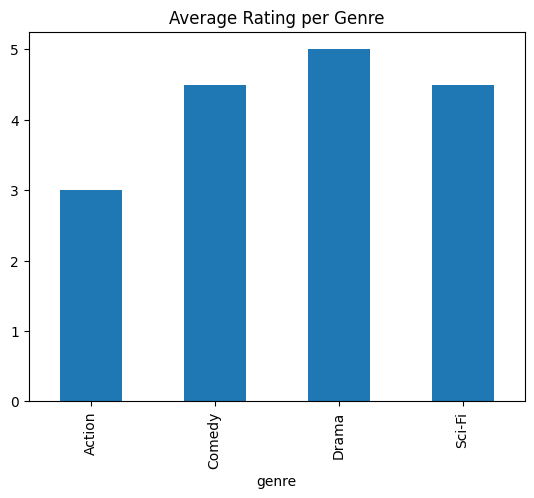

In [52]:
avg_rating_genre = merged.groupby("genre")["rating"].mean()
avg_rating_genre.plot(kind="bar", title="Average Rating per Genre")
plt.show()

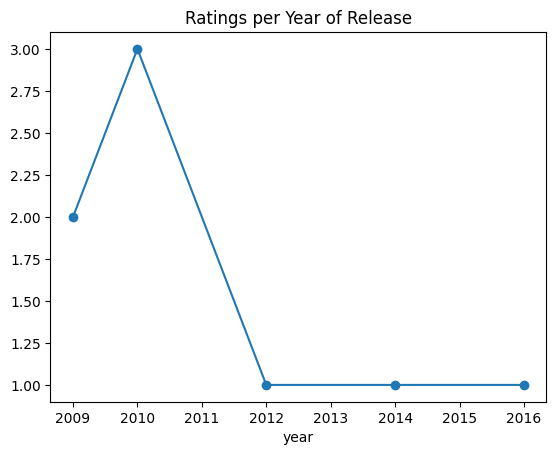

In [57]:
ratings_per_year = merged.groupby("year")["rating"].count()
ratings_per_year.plot(kind="line", marker="o", title="Ratings per Year of Release")
plt.show()

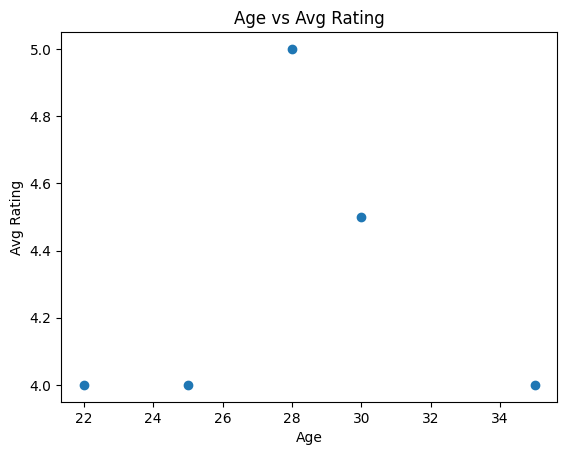

In [55]:
avg_rating_age = merged_users.groupby("age")["rating"].mean()
plt.scatter(avg_rating_age.index, avg_rating_age.values)
plt.title("Age vs Avg Rating")
plt.xlabel("Age")
plt.ylabel("Avg Rating")
plt.show()